In [90]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine
import statsmodels.api as sm 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse,rmse

# Display preferences
%matplotlib inline
import warnings
warnings.filterwarnings(action="ignore")

In [94]:
# Load the houseprices data from Thinkful's database.
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'


engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices_df = pd.read_sql_query('select * from houseprices',con=engine)
houseprices_df.head(2)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500


In [21]:
# data cleaning, exploratory data analysis, and feature engineering.

In [22]:
houseprices_df.isna().sum().sort_values(ascending=False).head(20)

poolqc          1453
miscfeature     1406
alley           1369
fence           1179
fireplacequ      690
lotfrontage      259
garagecond        81
garagetype        81
garageyrblt       81
garagefinish      81
garagequal        81
bsmtexposure      38
bsmtfintype2      38
bsmtfintype1      37
bsmtcond          37
bsmtqual          37
masvnrarea         8
masvnrtype         8
electrical         1
utilities          0
dtype: int64

In [23]:
houseprices_df.dropna(axis=1,inplace=True)

In [24]:
abs(houseprices_df.corr().saleprice).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
fireplaces       0.466929
bsmtfinsf1       0.386420
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
id               0.021917
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

In [26]:
houseprices_df.drop(columns=['halfbath','lotarea','bsmtfullbath','bsmtunfsf','bedroomabvgr' ,'kitchenabvgr','enclosedporch','screenporch'
                             ,'poolarea','mssubclass','overallcond','mosold','threessnporch','yrsold'
                             ,'lowqualfinsf','id','miscval' ,'bsmthalfbath','bsmtfinsf2' ],inplace=True)

In [27]:
houseprices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 43 columns):
mszoning         1460 non-null object
street           1460 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-null object
exterior2nd      1460 non-null object
exterqual        1460 non-null object
extercond        1460 non-null object
foundation       1460 non-null object
bsmtfinsf1       1460 non-null int64
totalbsmtsf      1460 n

In [69]:
numdf=houseprices_df[houseprices_df.select_dtypes(['int64']).columns]

Feature 0: 73.517789
Feature 1: 0.843670
Feature 2: 616.359369
Feature 3: 93.401515
Feature 4: 169.333333
Feature 5: 460.689145
Feature 6: 598.455854
Feature 7: 1701.105156
Feature 8: 189.009779
Feature 9: 1492.898809
Feature 10: 638.483201
Feature 11: 164.140399
Feature 12: 625.187597
Feature 13: 133.924032
Feature 14: 71.969199
Feature 15: 244.719920
Feature 16: 66.476582
Feature 17: 1162.841294
Feature 18: 40.308423
Feature 19: 204.433919
Feature 20: 69.904129
Feature 21: 66.293847
Feature 22: 171.793500
Feature 23: 165.566351


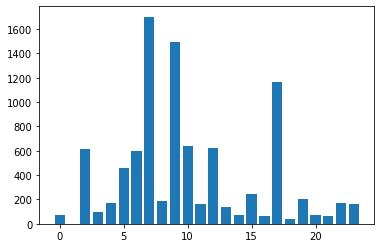

In [48]:
#Chi-Squared Feature Selection for categorical data:
cat_df=houseprices_df.select_dtypes('object').columns
X=houseprices_df[cat_df].drop(['condition2','roofstyle','exterior1st'],axis=1)
y=houseprices_df['saleprice']
X = X.astype(str)

from sklearn.model_selection import train_test_split
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


# prepare input data
from sklearn.preprocessing import OrdinalEncoder
def prepare_inputs(X_train, X_test):
	oe = OrdinalEncoder()
	oe.fit(X_train)
	X_train_enc = oe.transform(X_train)
	X_test_enc = oe.transform(X_test)
	return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	y_test_enc = le.transform(y_test)
	return y_train_enc, y_test_enc

# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)


from sklearn.feature_selection import SelectKBest, chi2

fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_train_enc, y_train)
X_train_fs = fs.transform(X_train_enc)
X_test_fs = fs.transform(X_test_enc)

import matplotlib.pyplot as plt
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [65]:
catdf=houseprices_df[['lotshape','landslope', 'neighborhood', 'bldgtype','housestyle', 'exterior2nd','heatingqc']]

In [66]:
catdf=pd.get_dummies(catdf,drop_first=True)

In [67]:
catdf

,lotshape_IR2,lotshape_IR3,lotshape_Reg,landslope_Mod,landslope_Sev,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,...,exterior2nd_Plywood,exterior2nd_Stone,exterior2nd_Stucco,exterior2nd_VinylSd,exterior2nd_Wd Sdng,exterior2nd_Wd Shng,heatingqc_Fa,heatingqc_Gd,heatingqc_Po,heatingqc_TA
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1456,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1457,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1458,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [73]:
new_df=pd.concat([catdf,numdf],axis=1)

In [80]:
# 3. split data into train and test sets where 20% of the data resides in the test set.
X=new_df.drop('saleprice',axis=1)
Y=new_df['saleprice']
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2)

In [81]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1168, 74), (292, 74), (1168,), (292,))

In [ ]:
# 4.Build several linear regression models including lasso, ridge, or elastic net, 
#and train them in the training set. Use k-fold cross-validation to select the best hyperparameters 
#if your models include one.

In [91]:
# Lasso regression
alpha=[np.power(10.0,p) for p in np.arange(-10,50,1)]
from sklearn.linear_model import LassoCV
Lar=LassoCV(alphas=alpha,cv=5)
Lar.fit(X_train, y_train)

# You are making predictions here
y_preds_train = Lar.predict(X_train)
y_preds_test = Lar.predict(X_test)

print("-----Lasso-----")
print("Best alpha value is: {}".format(Lar.alpha_))
print("R-squared of the model on the training set is: {}".format(Lar.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(Lar.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))



-----Lasso-----
Best alpha value is: 100.0
R-squared of the model on the training set is: 0.8455317174539922
-----Test set statistics-----
R-squared of the model on the test set is: 0.8364295879475074
Mean absolute error of the prediction is: 19679.837627881167
Mean squared error of the prediction is: 1000788145.355765
Root mean squared error of the prediction is: 31635.23581950615
Mean absolute percentage error of the prediction is: 10.648899978392832


In [92]:
# Ridge regression
alpha=[np.power(10.0,p) for p in np.arange(-10,50,1)]
from sklearn.linear_model import RidgeCV
Rr=RidgeCV(alphas=alpha,cv=5)
Rr.fit(X_train, y_train)

# You are making predictions here
y_preds_train = Rr.predict(X_train)
y_preds_test = Rr.predict(X_test)

print("-----Ridge-----")
print("Best alpha value is: {}".format(Rr.alpha_))
print("R-squared of the model on the training set is: {}".format(Rr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(Rr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))



-----Ridge-----
Best alpha value is: 1.0
R-squared of the model on the training set is: 0.8501658352080943
-----Test set statistics-----
R-squared of the model on the test set is: 0.8302356281499551
Mean absolute error of the prediction is: 20315.126426471703
Mean squared error of the prediction is: 1038685228.6999784
Root mean squared error of the prediction is: 32228.639882874028
Mean absolute percentage error of the prediction is: 11.059767652541327


In [93]:
# Elastic net regression
alpha=[np.power(10.0,p) for p in np.arange(-10,50,1)]
from sklearn.linear_model import ElasticNetCV
er=ElasticNetCV(alphas=alpha,cv=5)
er.fit(X_train, y_train)

# You are making predictions here
y_preds_train = er.predict(X_train)
y_preds_test = er.predict(X_test)

print("-----Elastic net-----")
print("Best alpha value is: {}".format(er.alpha_))
print("R-squared of the model on the training set is: {}".format(er.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(er.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))



-----Elastic net-----
Best alpha value is: 0.01
R-squared of the model on the training set is: 0.8466794565275839
-----Test set statistics-----
R-squared of the model on the test set is: 0.8356028356051286
Mean absolute error of the prediction is: 19708.02631528598
Mean squared error of the prediction is: 1005846541.510763
Root mean squared error of the prediction is: 31715.083816864855
Mean absolute percentage error of the prediction is: 10.727949955173614


In [ ]:
#questions:

In [95]:
houseprices_df.shape

(1460, 81)

In [102]:
houseprices_df.select_dtypes(['int64','float64']).columns.shape

(38,)

In [105]:
houseprices_df.isna().sum().sort_values(ascending=False).head(20)

poolqc          1453
miscfeature     1406
alley           1369
fence           1179
fireplacequ      690
lotfrontage      259
garagecond        81
garagetype        81
garageyrblt       81
garagefinish      81
garagequal        81
bsmtexposure      38
bsmtfintype2      38
bsmtfintype1      37
bsmtcond          37
bsmtqual          37
masvnrarea         8
masvnrtype         8
electrical         1
utilities          0
dtype: int64

(array([148., 723., 373., 135.,  51.,  19.,   4.,   3.,   2.,   2.]),
 array([ 34900., 106910., 178920., 250930., 322940., 394950., 466960.,
        538970., 610980., 682990., 755000.]),
 <a list of 10 Patch objects>)

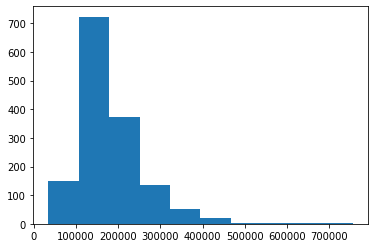

In [108]:
plt.hist(houseprices_df.saleprice)